<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelOneHotMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 74 (delta 22), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (74/74), done.
project  sample_data
MainModel.ipynb       MainModelOneHotMethod.ipynb	    README.md
MainModelKeras.ipynb  MainModelWithSingleBERTraining.ipynb  util.py
     |████████████████████████████████| 1.1MB 3.3MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=3aff83e32b72ec2b3efc93e607cc769355f12df58180f040f36d923002f86329
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 1.8MB/s 


In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [1 0 0 ... 1 0 1]
 ...
 [0 1 0 ... 1 1 0]
 [0 0 0 ... 0 1 0]
 [0 1 1 ... 1 0 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.60s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.22s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.63s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.37s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 15.82s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.42s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.82s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.29s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.62s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 14.16s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.08s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.23s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.54s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.80s
SNR: 1.000:
 -> BER: 0.50
 -> Total Time: 11.65s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.96s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.89s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.42s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.03s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.44s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.85s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 14.75s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.12s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.37s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.59s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.97s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 12.05s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.09s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.03s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.96s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.85s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 9.93s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.80s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.69s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.52s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.92s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.49s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.96s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 14.88s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.21s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.48s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.75s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.88s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 12.32s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.85s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.85s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.83s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.88s
SNR: 1.000:
 -> BER: 0.48
 -> Total Time: 9.42s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.84s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.52s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

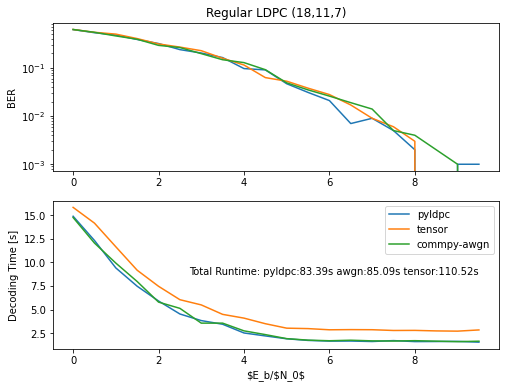

In [9]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [50]:
class GetOutOfLoop( Exception ):
    pass

In [30]:
# Define Model 

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

lr_x = tf.placeholder(dtype=tf.float32,shape=[])
#batch_size_x = tf.placeholder(tf.int32,shape=[])
input_message_x_label = tf.placeholder("int32", [None], name="input_message_x_label")
input_message_x = tf.placeholder("float32", [None, 2**input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, 2**input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length, 2**input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
loss = tf.losses.sparse_softmax_cross_entropy(labels=input_message_x_label,logits=dl_decoder_output)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_x).minimize (loss)

input_message_length= 11


In [51]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 2048)
(1, 1000)


In [52]:
batch_size = 500

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 10
outer_ephocs = 1
display_step = 10
num_of_batches = training_input_message.shape[1] / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
snr_min = 9.5
snr_max = 10.5
snr_step_size = 0.5
max_iteration = epochs * num_of_batches * (snr_max - snr_min) / snr_step_size
print ("max iteration :",max_iteration,"num_of_batches:", num_of_batches)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
    #for snr in (numpy.arange (snr_min, snr_max, SNR_STEP_SIZE)):
      sigma = 1.0*Snr2Sigma (snr)
      print ("Training for SNR=", snr, " sigma=", sigma, "iteratin:", oe) 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          i = i + 1
          x_train_batch_one_hot = training_input_message_one_hot [j*batch_size:(j+1)*batch_size]
          x_train_batch_one_hot = x_train_batch_one_hot.astype("float32")
          x_train_batch_label = training_input_message.reshape(training_input_message.shape[1]) [j*batch_size:(j+1)*batch_size]        
          if (i < 100): 
            lr = 0.1
          elif(i < 200):
            lr = 0.01
          else:
            lr = 0.001 
          _, l = train_sess.run ([optimizer, loss], feed_dict={input_message_x:x_train_batch_one_hot, awgn_noise_std_dev_x:sigma, lr_x:lr, input_message_x_label:x_train_batch_label.astype("int32")})
          if i % display_step == 0:          
            print('Step %i: Minibatch Loss: %f' % (i, l ))
          if (l < 0.2): 
            print ("Loss=", l)
            raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

batch_size: 500 num_of_batcches: 2.0
max iteration : 40.0 num_of_batches: 2.0
Training for SNR= 0.0  sigma= 1.0 iteratin: 0
Step 10: Minibatch Loss: 71.405441
Step 20: Minibatch Loss: 61.252342
Training for SNR= 0.5  sigma= 0.9440608762859234 iteratin: 0
Step 30: Minibatch Loss: 50.227055
Step 40: Minibatch Loss: 44.998871
Training for SNR= 1.0  sigma= 0.8912509381337456 iteratin: 0
Step 50: Minibatch Loss: 43.684658
Step 60: Minibatch Loss: 44.474495
Training for SNR= 1.5  sigma= 0.8413951416451951 iteratin: 0
Step 70: Minibatch Loss: 41.039810
Step 80: Minibatch Loss: 38.576099
Training for SNR= 2.0  sigma= 0.7943282347242815 iteratin: 0
Step 90: Minibatch Loss: 29.352547
Step 100: Minibatch Loss: 31.882673
Training for SNR= 2.5  sigma= 0.7498942093324559 iteratin: 0
Step 110: Minibatch Loss: 17.144974
Step 120: Minibatch Loss: 14.178627
Training for SNR= 3.0  sigma= 0.7079457843841379 iteratin: 0
Step 130: Minibatch Loss: 7.431777
Step 140: Minibatch Loss: 6.660699
Training for SNR=

In [53]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.92s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.72s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 2.53s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 3.39s
SNR: 0.000:
 -> BER: 0.43
 -> Total Time: 8.56s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.79s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.60s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 2.31s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.98s
SNR: 0.500:
 -> BER: 0.40
 -> Total Time: 7.68s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.76s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.54s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.33s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.12s
SNR: 1.000:
 -> BER: 0.31
 -> Total Time: 7.75s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.78s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.57s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

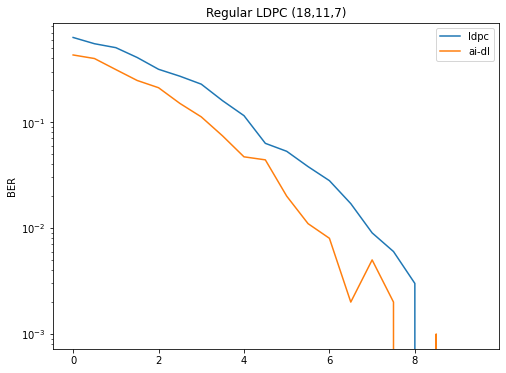

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [55]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 2048)
(1, 1000)


In [56]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.64s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.28s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.93s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.61s
SNR: 0.000:
 -> BER: 0.77
 -> Total Time: 6.46s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.65s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.30s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.93s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.59s
SNR: 0.500:
 -> BER: 0.76
 -> Total Time: 6.48s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.64s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.29s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.93s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.57s
SNR: 1.000:
 -> BER: 0.73
 -> Total Time: 6.43s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.64s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.24s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

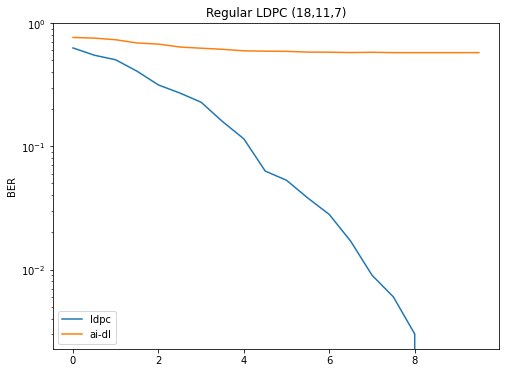

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()